In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from collections import Counter

import time
import warnings
# warnings.filterwarnings('ignore')

## Data Processing

In [2]:
def data_processor(oversampling=False,dist=0,std_vars=False):
    df = pd.read_csv('Datasets/train.csv', sep='|')
    features_to_select = ['trustLevel', 'totalScanTimeInSeconds', 'lineItemVoids',
                          'scansWithoutRegistration', 'quantityModifications', 
                          'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition']
    
    X = df[df.columns[:-1].tolist()]
    X = X[features_to_select]
    y = df[df.columns[-1]]

#     print("Train Test Split ratio is 0.33")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=dist, stratify=y)
    
    # Criação das variáveis de desvio padrão
    if (std_vars == True):
        for column in X_train:
            media = X_train.describe().loc['mean',column]
            dp = X_train.describe().loc['std',column]
#             duas_vezes_desvio_padrao = X_train.describe().loc['mean',column]+2*X_train.describe().loc['std',column]
            X_train.loc[:,"OutofStd_" + str(column) ] = (X_train[column]-media)/(1.0*dp)

        for column in X_test:
            media = X_train.describe().loc['mean',column]
            dp = X_train.describe().loc['std',column]
#             duas_vezes_desvio_padrao = X_train.describe().loc['mean',column]+2*X_train.describe().loc['std',column]
            X_test.loc[:,"OutofStd_" + str(column) ] = (X_test[column]-media)/(1.0*dp)
    
    if (oversampling == True): # Baseado em https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
        df_train = X_train.join(y_train) # .reset_index(drop=True)
        # Class count
        count_class_0, count_class_1 = df_train.fraud.value_counts()

        # Divide by class
        df_class_0 = df_train[df_train['fraud'] == 0]
        df_class_1 = df_train[df_train['fraud'] == 1]

        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

        print('Random over-sampling:')
        print(df_test_over.fraud.value_counts())

        df_test_over.fraud.value_counts().plot(kind='bar', title='Count (fraud)')   

        X_train = df_test_over[features_to_select]
        y_train = df_test_over[df_test_over.columns[-1]]
    
#     print(f"X_train shape: {X_train.shape}")
#     print(f"y_train shape: {y_train.shape}")
#     print(f"True class percentage in train set: {100*y_train.sum()/y_train.count()}%")
    
#     print(f"X_test shape: {X_test.shape}")
#     print(f"y_test shape: {y_test.shape}")
#     print(f"True class percentage in test set: {100*y_test.sum()/y_test.count()}%")

    return X_train, X_test, y_train, y_test

## Objective and Evaluation Functions

In [3]:
# baseado em https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
# user define objective function, given prediction, return gradient and second order gradient
# this is log likelihood loss

# Definição da função objetivo 'binary:logistic' padrão do xgboost
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
#     preds = 1.0 / (1.0 + np.exp(-preds)) # Esta linha está comentada devido a isso: https://github.com/dmlc/xgboost/issues/3892#issuecomment-441214227
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess

# def logreg_objective(y_true, y_pred):
#     weights = np.where(y_true == 1.0, 1.0, 1.0)
# #     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
#     grad = y_pred - y_true
#     hess = y_pred * (1.0 - y_pred)
#     return grad * weights, hess *  weights


def logreg_objective(y_true, y_pred):
    weights = np.where(y_true == 1.0, 1.0, 1.0)
#     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    grad = y_pred - y_true
    hess = y_pred * (1.0 - y_pred)
    return grad * weights, hess *  weights


# def logreg_objective(y_true, y_pred): # RICARDO
# #     Soff =  35*T*P -5*T -25*P +25,0000001 
# #     OBJ = 1/ ( Soff) 
# #     G = -(Soff)^(-2) * (35*T-25)
# #     H = 2*(Soff)^(-3) * (35*T-25)^(2)
#     weights = np.where(y_true == 1.0, 1.0, 1.0)
# #     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
# #     soff = 35*y_true*y_pred -5*y_true -25*y_pred +27
# #     inter = 35*y_true-25
#     soff = -35*y_true*y_pred + 5*y_true + 25*y_pred -27
#     inter = -35*y_true+25
#     grad = -(soff)**(-2) * (inter)
#     hess = 2*((soff)**(-3)) * ((inter)**(2))
#     return grad * weights, hess *  weights



# user defined evaluation function, return a pair metric_name, result
# NOTE: when you do customized loss function, the default prediction value is margin
# this may make builtin evaluation metric not function properly
# for example, we are doing logistic loss, the prediction is score before logistic transformation
# the builtin evaluation error assumes input is after logistic transformation
# Take this in mind when you use the customization, and maybe you need write customized evaluation function

# Definição da função de avaliação para a DMC 2019
def cupEvalScore(y_predicted, y_true):
    labels = y_true.get_label()
    y_predicted = np.round(y_predicted)
    matrix = metrics.confusion_matrix(labels, y_predicted)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    return 'cupScore', weightSum

def cupEvalScore_negative(y_predicted, y_true): # versão negativa da função
    labels = y_true.get_label()
    y_predicted = np.round(y_predicted)
    matrix = metrics.confusion_matrix(labels, y_predicted)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,25,5,-5]))
    return 'cupScore', weightSum

def cupEvalScoreNorm_negative(y_predicted, y_true): # versão negativa da função
    labels = y_true.get_label()
    y_predicted = np.round(y_predicted)
    matrix = metrics.confusion_matrix(labels, y_predicted)
    totalArray = np.reshape(matrix, 4)
    weightSum = np.sum(totalArray*np.array([0,25,5,-5]))/np.sum(totalArray)
    return 'cupScore', weightSum

# training with customized objective, we can also do step by step training
# simply look at xgboost.py's implementation of train
# bst = xgb.train(param, dtrain, num_round, watchlist, obj=logregobj, feval=evalerror)

## Training, Prediction and Results

In [4]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=False, cv_folds=3, early_stopping_rounds=10):
    # Definindo o classificador xGBoost com função objetivo (objective=logreg_objective) 
    # e função de avaliação (feval=cupEvalScore_negative)
    alg = XGBClassifier(booster='gbtree', 
                        learning_rate=0.01, n_estimators=9001, max_depth=20,
                        min_child_weight=2, gamma=0.2, subsample=0.2, colsample_bytree=1.0,
                        objective=logreg_objective, feval=cupEvalScoreNorm_negative,
                        nthread=7, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        print(alg.get_xgb_params())
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        print('running cross validation')
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          verbose_eval=1000, stratified=True,
                          feval=cupEvalScore_negative, maximize=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_xgb_params())
        print('Best number of trees = {}\n'.format(cvresult.shape[0]))
#         print(cvresult)

#     print('\nStart Training')
#     print('xGBoost params:', alg.get_xgb_params(), '\n')
    alg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=cupEvalScoreNorm_negative, verbose=False)
#     alg.fit(X_train, y_train, verbose=1000)

    print("\nStart Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    print("Acurracy: %.4g" % metrics.accuracy_score(y_test, predictions))
    print("AUC: %f" % metrics.roc_auc_score(y_test, predictions))
    print("AUC_prob: %f" % metrics.roc_auc_score(y_test, pred_proba))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
#     print (false_positive_rate[1], true_positive_rate[1], auc(false_positive_rate, true_positive_rate))
    print("F1 Score: %f" % metrics.f1_score(y_test, predictions))
    matrix = metrics.confusion_matrix(y_test, predictions)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    totalArray = np.reshape(matrix, 4)
    print(f"Score Cup: {weightSum}")
    print(f"Score Cup Norm: {weightSum/np.sum(totalArray)}")
    print(f"Confusion matrix: \n{matrix}")
    print(f"Percentage of positives: \n{100*np.sum(totalArray*np.array([0,1,0,1]))/np.sum(totalArray)}")
    print(f"Real positives: \n{100*np.sum(totalArray*np.array([0,0,1,1]))/np.sum(totalArray)}")

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())




 RODADA  0 



/home/ruan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ruan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



Start Predicting
Acurracy: 0.9855
AUC: 0.881501
AUC_prob: 0.993186
F1 Score: 0.852459
Score Cup: 65
Score Cup Norm: 0.10466988727858294
Confusion matrix: 
[[586   1]
 [  8  26]]
Percentage of positives: 
4.3478260869565215
Real positives: 
5.475040257648954


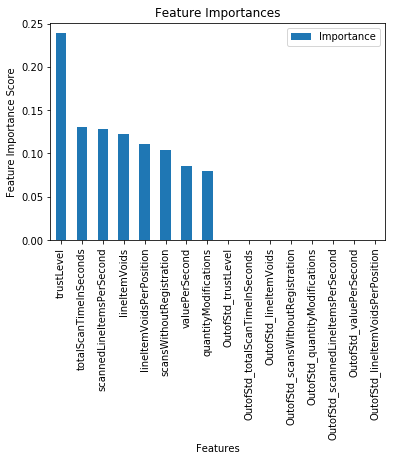

                              Features  Importance
0                           trustLevel    0.239153
1               totalScanTimeInSeconds    0.130257
5            scannedLineItemsPerSecond    0.127987
2                        lineItemVoids    0.122459
7             lineItemVoidsPerPosition    0.110801
3             scansWithoutRegistration    0.104228
6                       valuePerSecond    0.085263
4                quantityModifications    0.079852
8                  OutofStd_trustLevel    0.000000
9      OutofStd_totalScanTimeInSeconds    0.000000
10              OutofStd_lineItemVoids    0.000000
11   OutofStd_scansWithoutRegistration    0.000000
12      OutofStd_quantityModifications    0.000000
13  OutofStd_scannedLineItemsPerSecond    0.000000
14             OutofStd_valuePerSecond    0.000000
15   OutofStd_lineItemVoidsPerPosition    0.000000
['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'lineItemVoids', 'lineItemVoidsPerPosition', 'scansWithoutRegis

In [5]:
if __name__ == "__main__":
    start = time.time()
#     for count in range(10):
    print('\n\n\n RODADA ', 0, '\n')
    X_train, X_test, y_train, y_test = data_processor(dist=0,std_vars=True)
    xgb_classifier(X_train, X_test, y_train, y_test)

print("Total Time is: ", (time.time() - start)/60)